In [9]:
%matplotlib widget

In [10]:
import matplotlib.pyplot as plt
import xtrack as xt
import numpy as np

### Load the model

In [11]:
env = xt.Environment.from_json('./pimm_extr.json')
env.vars.load_json('./pimm_strengths.json')

line = env.ring
line.configure_bend_model(num_multipole_kicks=5)

tw = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/195 [00:00<?, ?it/s]

Done loading line from dict.           


### Bring horizontal tune close to 3rd order resonance

In [12]:
opt = line.match(
    solve=False, # <- prepare the match without running it
    compute_chromatic_properties=False,
    method='4d',
    vary=[
        xt.Vary('kqfa', limits=(0, 10),  step=1e-3),
        xt.Vary('kqfb', limits=(0, 10),  step=1e-3),
        xt.Vary('kqd', limits=(-10, 0), step=1e-3),
    ],
    targets=[
        xt.TargetSet(qx=1.665, qy=1.72, tol=1e-4),
        xt.TargetSet(dx=0, at='mid.lss.0', tol=2e-3),
        xt.TargetSet(dx=0, at='mid.lss.1', tol=2e-3),
    ]
)
opt.step(20)

                                             
Optimize - start penalty: 0.277                             
Matching: model call n. 11 penalty = 3.1019e-04              
Optimize - end penalty:  0.000310192                            


### Use MAD-NG to compute change of sextupolar Resonant Driving Term 

In [60]:
# Compute effect of mse change on resonance excitation
env['kse'] = 0
tw_ng_mse_0 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 1
tw_ng_mse_1 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 2
tw_ng_mse_2 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 3
tw_ng_mse_3 = line.madng_twiss(rdts=['f3000'])
env['kse'] = 4
tw_ng_mse_4 = line.madng_twiss(rdts=['f3000'])

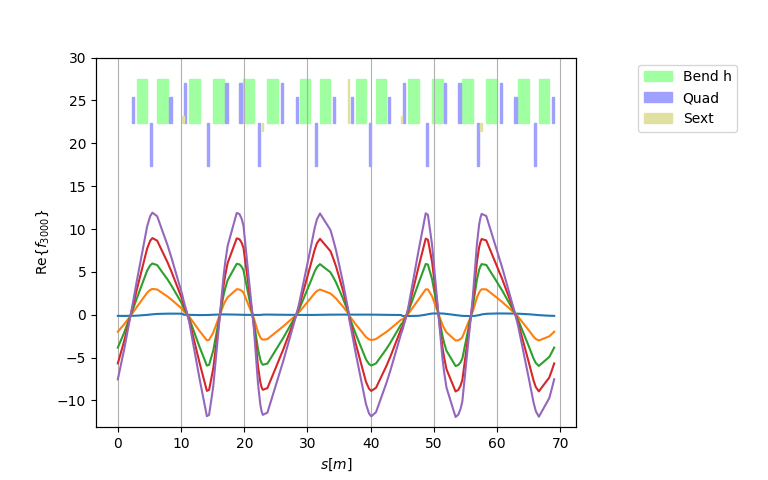

In [63]:
# Plot RDT vs mse strength
pl = tw_ng_mse_4.plot(lattice_only=True)
ax = pl.left

ax.plot(tw_ng_mse_0.s, np.real(tw_ng_mse_0.f3000))
ax.plot(tw_ng_mse_1.s, np.real(tw_ng_mse_1.f3000))
ax.plot(tw_ng_mse_2.s, np.real(tw_ng_mse_2.f3000))
ax.plot(tw_ng_mse_3.s, np.real(tw_ng_mse_3.f3000))
ax.plot(tw_ng_mse_4.s, np.real(tw_ng_mse_4.f3000))

pl.ylim(left_hi=30, right_lo=-20, right_hi=20,
        lattice_hi=1.5, lattice_lo=-7)
ax.set_ylabel(r'Re$\{f_{3000}\}$');

### Observe deformation of phase space when exciting the resonance

In [64]:
# Generate 20 particles on the x axis
x_gen = np.linspace(0, 0.5e-2, 20)
p0 = line.build_particles(x=x_gen, px=0, y=0, py=0, zeta=0, delta=0)

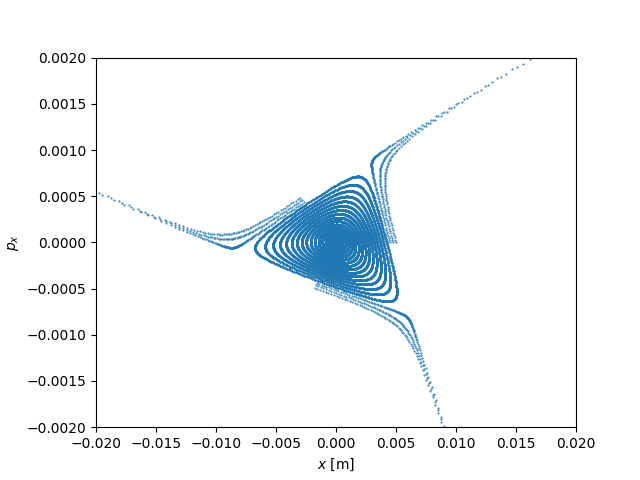

In [71]:
# Set extraction sextupole
env['kse'] = 5

# Track 1000 turns
line.track(p0.copy(), num_turns=1000, turn_by_turn_monitor=True)
rec = line.record_last_track

# Plot turn-by-turn data
plt.figure()
plt.plot(rec.x.T, rec.px.T, '.', markersize=1, color='C0')
plt.xlabel(r'$x$ [m]'); plt.ylabel(r'$p_x$'), plt.xlim(-2e-2, 2e-2); plt.ylim(-2e-3, 2e-3)
plt.subplots_adjust(left=.15)